In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ml_pjct1

/content/drive/MyDrive/ml_pjct1


In [ ]:
ls

a_exsrc10.png       b_ppl1.jpeg             ML_BLURimg.ipynb
a_exsrc11.png       b_ppl2.png              Plate_Contour.png
a_exsrc12.png       b_ppl3.png              Possible_contours.png
a_exsrc13.png       b_ppl4.png              Ppl_Blurred/
a_exsrc1.png        b_ppl5.png              Ppl_cropImg/
a_exsrc2.png        b_ppl6.png              Ppl_face/
a_exsrc3.png        Car_Blurred/            Ppl_faceBlurred/
a_exsrc4.png        Car_cropImg/            Preprocess.png
a_exsrc5.png        Car_Detection.ipynb     Rotated.png
a_exsrc6.png        Contour_candidates.png  Start.png
a_exsrc7.png        contouring.png          z_FINALFINAL.png
a_exsrc8.png        final_res.png           z_FINAL_RESULT.png
a_exsrc9.png        grayscaled_plate.png
a_FINAL_RESULT.png  ML_BLURcar.ipynb


In [ ]:
!sudo apt install tesseract-ocr-kor
!pip install pytesseract
!pip install Pillow==9.0.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-kor is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time
import os
import copy
import cv2
import pytesseract

from google.colab.patches import cv2_imshow

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [67]:
def Blur_Plate(path):
  try:
    img = cv2.imread('Car_cropImg/'+str(path))
    orig_img = img.copy()
    height, width, channel = img.shape
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(12,8))
    plt.subplot(121),plt.imshow(img[:,:,::-1],'gray')
    plt.subplot(122),plt.imshow(imgray,'gray')
    plt.axis('off')
    plt.savefig("Start")
    plt.show()
    #=============================================================================
    # Edge를 뚜렷하게 하기 위해 가우시안 블러 적용
    blur = cv2.GaussianBlur(imgray,(5,5),0)

    # Adaptive Threshold 적용
    thr = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    plt.figure(figsize=(20,20))

    # dilation - erode with / without blur 
    kernel = np.ones((3,3),np.uint8)
    dil = cv2.dilate(blur,kernel,iterations=1)
    ero = cv2.erode(blur,kernel,iterations=1)
    morph = dil - ero

    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    topHat = cv2.morphologyEx(imgray, cv2.MORPH_TOPHAT, kernel2)
    blackHat = cv2.morphologyEx(imgray, cv2.MORPH_BLACKHAT, kernel2)

    imgGrayscalePlusTopHat = cv2.add(imgray, topHat)
    subtract = cv2.subtract(imgGrayscalePlusTopHat, blackHat)
    thr2 = cv2.adaptiveThreshold(subtract,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    
    # cv2_imshow(thr)
    # cv2_imshow(morph)
    cv2_imshow(imgray)

    plt.figure(figsize=(12,8))
    plt.subplot(221), plt.imshow(blur,'gray')
    plt.title("blurred")
    plt.subplot(222), plt.imshow(thr,'gray')
    plt.title("after Adaptive Threshold")
    plt.subplot(223), plt.imshow(morph,'gray')
    plt.title("Dilation - Erode (with blur)")
    plt.subplot(224), plt.imshow(thr2,'gray')
    plt.title("top-black AT")
    plt.savefig("Preprocess")
    plt.show()
    #=============================================================================
    # canny 하지 않고
    # 그냥 Adaptive Thresh가 젤 잘나옴 
    orig_img = img.copy()
    cnts,contours = cv2.findContours(thr,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[1], cv2.findContours(thr,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]
    contours_dict = []
    pos_cnt = list()
    box1 = list()

    contours_dict = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(orig_img, pt1=(x, y), pt2=(x+w, y+h), color=(0, 255, 0), thickness=2)
        
        # insert to dict
        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
        })

    plt.figure(figsize=(12,8))         
    plt.imshow(orig_img[:,:,::-1])   
    plt.savefig("Contour_candidates")
    plt.show()  
    #=============================================================================
    orig_img = img.copy()
    count = 0

    for d in contours_dict:
        rect_area = d['w']*d['h'] # 영역 크기
        aspect_ratio = d['w'] / d['h']
        
        if (aspect_ratio >= 0.3) and (aspect_ratio <= 1.0) and (rect_area >= 100) and (rect_area <= 800):
            cv2.rectangle(orig_img,(d['x'],d['y']),(d['x']+d['w'],d['y']+d['h']),(0,255,0),2)
            d['idx'] = count
            count += 1
            pos_cnt.append(d)
            

    plt.figure(figsize=(20,20))         
    plt.imshow(orig_img[:,:,::-1])
    plt.savefig("Possible_contours")
    plt.show()
    #=============================================================================  
    MAX_DIAG_MULTIPLYER = 5 # contourArea의 대각선 x5 안에 다음 contour가 있어야함
    MAX_ANGLE_DIFF = 12.0  # contour와 contour 중심을 기준으로 한 각도가 n 이내여야함
    MAX_AREA_DIFF = 0.5 # contour간에 면적 차이가 크면 인정하지 않겠다.
    MAX_WIDTH_DIFF = 0.8 # contour간에 너비 차이가 크면 인정 x
    MAX_HEIGHT_DIFF = 0.2 # contour간에 높이 차이가 크면 인정 x
    MIN_N_MATCHED = 4 # 위의 조건을 따르는 contour가 최소 3개 이상이어야 번호판으로 인정
    orig_img = img.copy()
    def find_number(contour_list):
        matched_result_idx = []
        
        # contour_list[n]의 keys = dict_keys(['contour', 'x', 'y', 'w', 'h', 'cx', 'cy', 'idx'])
        for d1 in contour_list:
            matched_contour_idx = []
            for d2 in contour_list:      # for문을 2번 돌면서 contour끼리 비교해줄 것
                if d1['idx'] == d2['idx']:   # idx가 같다면 아예 동일한 contour이기에 패스
                    continue
                    
                dx = abs(d1['cx']-d2['cx'])  # d1, d2 중앙점 기준으로 x축의 거리
                dy = abs(d1['cy']-d2['cy'])  # d1, d2 중앙점 기준으로 y축의 거리
                # 이를 구한 이유는 대각 길이를 구하기 위함 / 피타고라스 정리
                
                # 기준 Contour 사각형의 대각선 길이 구하기
                diag_len = np.sqrt(d1['w']**2+d1['w']**2)
                
                # contour 중심간의 대각 거리
                distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'],d2['cy']]))
                
                # 각도 구하기
                # 빗변을 구할 때, dx와 dy를 알기에 tan세타 = dy / dx 로 구할 수 있다. 
                # 여기서 역함수를 사용하면    세타 =  arctan dy/dx 가 된다.
                if dx == 0:
                    angle_diff = 90   # x축의 차이가 없다는 것은 다른 contour가 위/아래에 위치한다는 것
                else:
                    angle_diff = np.degrees(np.arctan(dy/dx))  # 라디안 값을 도로 바꾼다. 
                
                # 면적의 비율 (기준 contour 대비)
                area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w']*d1['h'])
                # 너비의 비율
                width_diff = abs(d1['w']-d2['w']) / d1['w']
                # 높이의 비율
                height_diff = abs(d1['h']-d2['h']) / d2['h']    
                    
                # 이제 조건에 맞는 idx만을 matched_contours_idx에 append할 것이다.
                if distance < diag_len * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF \
                and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF \
                and height_diff < MAX_HEIGHT_DIFF:
                    # 계속 d2를 번갈아 가며 비교했기에 지금 d2 넣어주고
                    matched_contour_idx.append(d2['idx'])
                    
            # d1은 기준이었으니 이제 append
            matched_contour_idx.append(d1['idx'])
            
            # 앞서 정한 후보군의 갯수보다 적으면 탈락
            if len(matched_contour_idx) < MIN_N_MATCHED:
                continue
            
            # 최종 contour를 입력
            matched_result_idx.append(matched_contour_idx)
            
            # 최종에 들지 못한 아닌애들도 한 번 더 비교
            unmatched_contour_idx = []
            for d4 in contour_list:
                if d4['idx'] not in matched_contour_idx:
                    unmatched_contour_idx.append(d4['idx'])
            
            # np.take(a,idx)   a배열에서 idx를 뽑아냄
            unmatched_contour = np.take(pos_cnt,unmatched_contour_idx)
            
            # 재귀적으로 한 번 더 돌림
            recursive_contour_list = find_number(unmatched_contour)
            
            # 최종 리스트에 추가
            for idx in recursive_contour_list:
                matched_result_idx.append(idx)
                
            break
            
        return matched_result_idx

    result_idx = find_number(pos_cnt)

    matched_result = []

    for idx_list in result_idx:
        matched_result.append(np.take(pos_cnt,idx_list))
        
    # pos_cnt 시각화

    for r in matched_result:
        for d in r:
            cv2.rectangle(orig_img,(d['x'],d['y']),(d['x']+d['w'],d['y']+d['h']),(0,255,0),2)
            
    plt.figure(figsize=(20,20))        
    plt.imshow(orig_img[:,:,::-1])
    plt.savefig("Plate_Contour")
    plt.show()
    #=============================================================================
    PLATE_WIDTH_PADDING = 1.3 
    PLATE_HEIGHT_PADDING = 1.5 
    MIN_PLATE_RATIO = 3
    MAX_PLATE_RATIO = 10

    plate_imgs = []
    plate_infos = []

    for i, matched_chars in enumerate(matched_result):
        sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
        
        # 합집합 구하는 것 처럼 교집합([0]['x']) 제거 
        # 그리고 패딩
        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
        
        sum_height = 0
        for d in sorted_chars:
            sum_height += d['h']
            
        # 평균 구하고 패딩
        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
        
        # 삐뚫어져있기에 각도를 구해야함 
        
        # 높이는 알고 빗변도 알기에 세타를 구할 수 있음 (기울어진 정도)
        
        # 높이
        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        # 빗변
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )
        # arcsin을 이용함 
        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
        
        rotation_matrix = cv2.getRotationMatrix2D((plate_cx, plate_cy), angle, scale=1.0)
        
        img_rotated = cv2.warpAffine(thr, M=rotation_matrix, dsize=(width, height))
        
        # 원하는 부분만 잘라냄
        img_cropped = cv2.getRectSubPix(
            img_rotated, 
            patchSize=(int(plate_width), int(plate_height)), 
            center=(int(plate_cx), int(plate_cy))
        )
        # h/w < Min   or   Max < h/w < Min  해당하면 패스  해당하지 않을경우 append
        if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or \
        img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
            continue
        
        plate_imgs.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })
        
        plt.subplot(len(matched_result), 1, i+1)
        plt.savefig("grayscaled_plate")
        plt.imshow(img_cropped, cmap='gray')
    #=============================================================================
    plt.figure(figsize=(12,8))
    plt.subplot(121), plt.imshow(thr,'gray'), plt.title("Original")
    plt.subplot(122), plt.imshow(img_rotated,'gray'), plt.title("Rotated")
    plt.savefig("Rotated")
    plt.show()
    #=============================================================================
    MIN_AREA = 80
    MIN_WIDTH, MIN_HEIGHT = 2, 8
    MIN_RATIO, MAX_RATIO = 0.2, 1.0

    longest_idx, longest_text = -1, 0
    plate_chars = []

    for i, plate_img in enumerate(plate_imgs):
        plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
        _, plate_img = cv2.threshold(plate_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        # 위와 같이 contours 다시 찾기
        _, contours = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)[1], cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)[0]
        
        plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
        plate_max_x, plate_max_y = 0, 0

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            area = w * h
            ratio = w / h

            if area > MIN_AREA \
            and w > MIN_WIDTH and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h
                    
        img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
        
        # 한번더 blur, threshold
        img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
        _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7')
        
        result_chars = ''
        has_digit = False
        for c in chars:
            if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
                if c.isdigit():
                    has_digit = True
                result_chars += c
        
        print(result_chars)
        plate_chars.append(result_chars)

        if has_digit and len(result_chars) > longest_text:
            longest_idx = i

        plt.subplot(len(plate_imgs), 1, i+1)
        plt.imshow(img_result, cmap='gray')
    #=============================================================================
    info = plate_infos[longest_idx]
    chars = plate_chars[longest_idx]

    print(chars)

    orig_img = img.copy()

    cv2.rectangle(orig_img, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(0,255,0), thickness=2)

    cv2.imwrite('./res/' +chars[:7] + '.jpg', orig_img)

    plt.figure(figsize=(12, 10))
    plt.imshow(orig_img[:,:,::-1])
    #=============================================================================
    info = plate_infos[longest_idx]
    chars = plate_chars[longest_idx]

    print(chars)

    orig_img2 = img.copy()

    # boundingRect 표시!
    # cv2.rectangle(orig_img, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(0,255,0), thickness=2)

    cv2.imwrite('./res/' +chars[:7] + '.jpg', orig_img)

    plt.figure(figsize=(12, 10))
    plt.imshow(orig_img2[:,:,::-1])
    plt.savefig("contouring")
    #=============================================================================
    # 원본 이미지에서 번호판 영역을 추출합니다
    img_m = orig_img2[info['y']:info['y']+info['h'],info['x']:info['x']+info['w']]
    plt.imshow(img_m)
    plt.show()
    # 1. 사각영역을 먼저 골라낸 후
    # 2. 잘라낸 이미지의 크기를 축소한다
    # 3. 다시 크기를 확대하여 원본 이미지를 대체한다.

    img_m_resize = cv2.resize(img_m,(0,0),fx=0.1,fy=0.1)
    plt.imshow(img_m_resize)
    print(img_m_resize.shape)
    #=============================================================================
    h,w,_ = img_m.shape
    orig_img2 = img.copy()
    img_m_resize = cv2.resize(img_m_resize,(w,h))
    orig_img2[info['y']:info['y']+info['h'],info['x']:info['x']+info['w']] = img_m_resize
    tosave = Image.fromarray(orig_img2[:,:,::-1])
    plt.figure(figsize=(12,8))
    plt.imshow(orig_img2[:,:,::-1])
    plt.savefig("final_res")
    plt.show()
    tosave.save('Car_Blurred/Blrd'+ str(path))
    #=============================================================================
    
    print()
    print()

  except:
    print()
    print("NOTHING TO BLUR")
    print()



In [50]:
def rm(path):
  under_path = os.listdir(path)
  for i in range (0, len(under_path), 1):
    os.remove(path + '/' + under_path[i])
    print(str(under_path[i])+' removed')

def rmfile(path):
  try:
    os.remove(path)
  except: pass
  print(str(path)+' removed')

In [51]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=20, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  cnt = 0
  pplcnt = 0
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 50)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()
  try:
    pplfont = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 30)
  except IOError:
    print("Font not found, using default font.")
    pplfont = ImageFont.load_default()


  for i in range(0, len(boxes), 1):  
    if class_names[i].decode("ascii") == "Car" and scores[i] >= min_score :
      cnt += 1
      ymin, xmin, ymax, xmax = tuple(boxes[i])

      abord = False
      afford = 200
      for p in range (0, len(carbox), 1):
        if (abs(int(xmin*imgX) - carbox[p][0]) <= afford or int(xmin*imgX) >= carbox[p][0]) and (abs(int(ymin*imgY) - carbox[p][1]) <= afford or int(ymin*imgY) >= carbox[p][1]) and (abs(int(xmax*imgX) - carbox[p][2]) <= afford or int(xmax*imgX) <= carbox[p][2]) and (abs(int(ymax*imgY) - carbox[p][3]) <= afford or int(ymax*imgY) <= carbox[p][3]):
          print(str(len(carbox)), "already exists")
          abord = True

      if abord == True:
        continue
      display_str = "{}: {}%".format(class_names[i].decode("ascii") + str(len(carbox)), int(100 * scores[i]))
      to_append = []
      to_append.append(int((xmin*imgX)*(1.05)))
      to_append.append(int((ymin*imgY)*(1.05)))
      to_append.append(int((xmax*imgX)*(0.95)))
      to_append.append(int(ymax*imgY))
      to_append = tuple(to_append)
      carbox.append(to_append)
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
    if class_names[i].decode("ascii") == "Person" or class_names[i].decode("ascii") == "Man":
      pplcnt += 1
      ymin, xmin, ymax, xmax = tuple(boxes[i])

      abord = False
      afford = 48
      for p in range (0, len(pplbox), 1):
        if (abs(int(xmin*imgX) - pplbox[p][0]) <= afford or int(xmin*imgX) >= pplbox[p][0]) and (abs(int(ymin*imgY) - pplbox[p][1]) <= afford or int(ymin*imgY) >= pplbox[p][1]) and (abs(int(xmax*imgX) - pplbox[p][2]) <= afford or int(xmax*imgX) <= pplbox[p][2]) and (abs(int(ymax*imgY) - pplbox[p][3]) <= afford or int(ymax*imgY) <= pplbox[p][3]):
          print(str(len(pplbox)), "already exists")
          abord = True

      if abord == True:
        continue

      display_str = "{}".format("Person" + str(len(pplbox)) + " ")
      to_append = []
      to_append.append(int(xmin*imgX))
      to_append.append(int(ymin*imgY))
      to_append.append(int(xmax*imgX))
      to_append.append(int(ymax*imgY))
      to_append = tuple(to_append)
      pplbox.append(to_append)
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          pplfont,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [52]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  # print(result["detection_boxes"])
  # print(result["detection_class_entities"])
  # print(result["detection_scores"])

  display_image(image_with_boxes)


In [53]:
def cropimg(path):
  try: 
    print("Found", str(len(carbox)), "Car")
    for i in range(0, len(carbox), 1):
      print(carbox[i])
      orgnimg = Image.open(path)
      crpimg = orgnimg.crop(carbox[i])
      crpimg.save('Car_cropImg/car'+ str(i) +'.png')
      print('car' + str(i) + ' saved')
      crpimgBound.append(carbox[i])
  except:
    print("too small to recognize. no need to mosaic")

In [54]:
def pplcrop(path):
  print("Found", str(len(pplbox)), "Person")
  for i in range(0, len(pplbox), 1):
    print(pplbox[i])
    orgnimg = Image.open(path)
    crpimg = orgnimg.crop(pplbox[i])
    crpimg.save('Ppl_cropImg/ppl'+ str(i) +'.png')
    print('ppl' + str(i) + ' saved')
    crpimgBound.append(pplbox[i])
  

In [55]:
def pasteCar(path):
  base = Image.open(path)

  for i in range(0, len(crpimgBound), 1):
    
    if crpimgBound[i]: 
      ImgToPaste = Image.open('Car_Blurred/Blrdcar'+ str(i) + '.png')
      base.paste(ImgToPaste, crpimgBound[i][:2])

  base.save('z_FINAL_RESULT.png')

file to Blur : a_exsrc10.png
car0.png removed
car1.png removed
car2.png removed
car3.png removed
car4.png removed
z_FINAL_RESULT.png removed
z_FINALFINAL.png removed
Found 100 objects.
Inference time:  34.68479347229004
5 already exists
5 already exists
5 already exists
5 already exists
5 already exists
5 already exists
5 already exists
5 already exists
5 already exists
5 already exists
[(376, 1352, 935, 1670), (2114, 1365, 2835, 1807), (7, 1335, 358, 1887), (1047, 1388, 1612, 1838), (1960, 1397, 2052, 1568)]
[]
Found 5 Car
(376, 1352, 935, 1670)
car0 saved
(2114, 1365, 2835, 1807)
car1 saved
(7, 1335, 358, 1887)
car2 saved
(1047, 1388, 1612, 1838)
car3 saved
(1960, 1397, 2052, 1568)
car4 saved
Found 0 Person


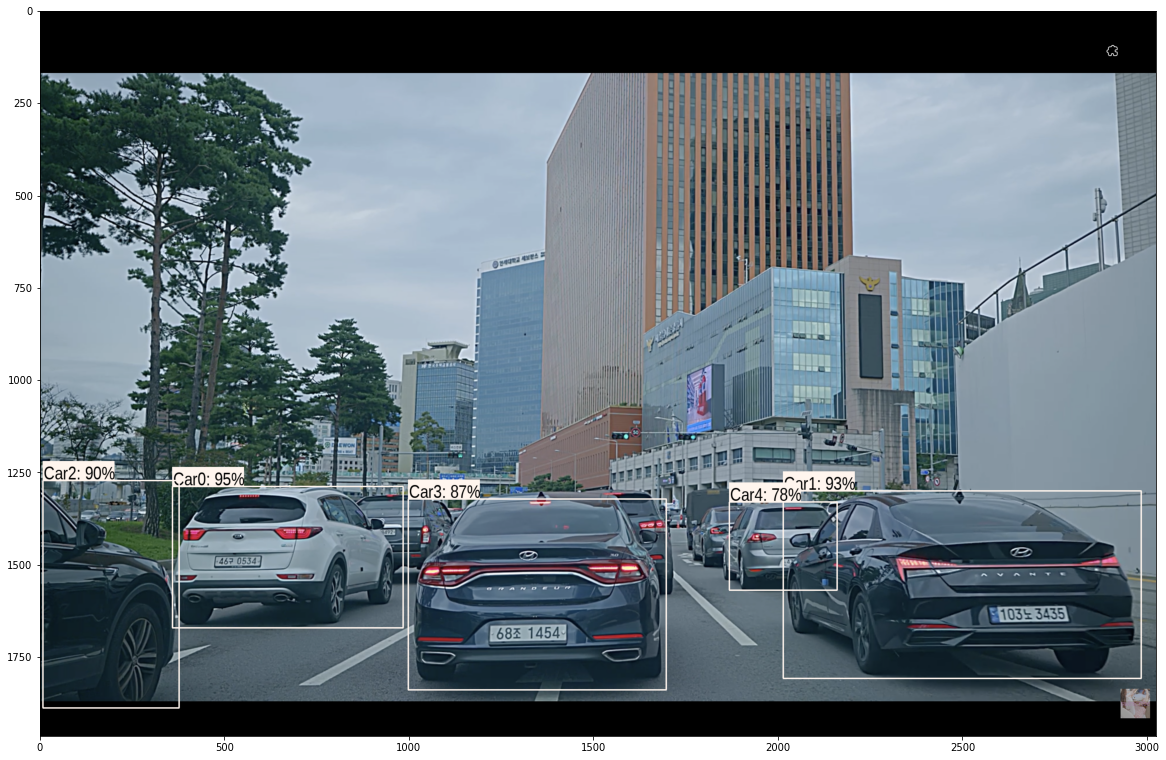

In [56]:
path = str(input('file to Blur : ')).strip()

rm('Car_cropImg')
rm('Car_Blurred')
rm('Ppl_Blurred')
rm('Ppl_cropImg')
rm('Ppl_face')
rm('Ppl_faceBlurred')
rmfile('z_FINAL_RESULT.png')
rmfile('z_FINALFINAL.png')

carbox = []
pplbox = []
crpimgBound = []

imgsz = Image.open(path).size
imgX = imgsz[0]
imgY = imgsz[1]

run_detector(detector, path)
print(carbox)
print(pplbox)
cropimg(path)
pplcrop(path)

In [68]:
crpimg = os.listdir('Car_cropImg')
for i in range(0, len(crpimg), 1):
  if i == len(crpimg)-1:
    print(crpimg[i], '['+str(i)+']')
    continue
  print(crpimg[i], '['+str(i)+']', end = " / ")

print()
exec = str(input("Enter Number of Mosaic Exception: "))
print()

exec = exec.split(",")
for i in range(0, len(exec), 1):
  try:
    exec[i] = int(exec[i])
  except:
    exec.remove(exec[i])

for i in range(0, len(exec), 1):
  crpimg[exec[i]] = False

print()

for i in range(0, len(crpimg), 1):
  if crpimg[i]:
    print('Blurring '+ crpimg[i] + " ···")
    Blur_Plate(crpimg[i])
    print("Blurred "+ crpimg[i])

print("Blurring each image completed")

blrdlst = os.listdir('Car_Blurred')

p = []

for i in range (0, len(blrdlst), 1):
  p.append(int(blrdlst[i][-5]))

for i in range(0, len(crpimgBound), 1):
  if i in p:
    continue
  crpimgBound[i] = False

pasteCar(path)

print("Pasting Blurred image completed. Blurring Plate(s) Ended")

Output hidden; open in https://colab.research.google.com to view.

In [58]:
def Mosaic(path, ratio=0.05):
    src = cv2.imread(path)
    pathlst = path.split("/")
    small = cv2.resize(src, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    mosaic = cv2.resize(small, src.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
    SavedPath = 'Ppl_faceBlurred/Blrd_'+pathlst[1]
    cv2.imwrite(SavedPath, mosaic)
    return SavedPath

In [59]:
def Blur_Face(path, i):
  path = 'Ppl_cropImg/'+ path
  # openim('Ppl_cropImg/'+ path)
  # to_crop_for_Mosaic = cv2.imread(path)
  orgn = Image.open(path)
  imgsz = orgn.size
  imgX, imgY = imgsz[0], imgsz[1]
  CropBound = (0, 0, imgX, int(imgY*0.3))
  Cropped = orgn.crop(CropBound)
  CroppedPath = 'Ppl_face/'+ 'face' + str(i) + '.png'
  Cropped.save(CroppedPath)
  to_paste_PATH = Mosaic(CroppedPath)
  to_paste = Image.open(to_paste_PATH)
  orgn.paste(to_paste, CropBound[:2])
  orgn.save('Ppl_Blurred/' + to_paste_PATH.split('/')[1])
  print('Ppl_Blurred/' + to_paste_PATH.split('/')[1])
  

In [60]:
pplcrop = os.listdir('Ppl_cropImg')
for i in range(0, len(pplcrop), 1):
  if i == len(pplcrop)-1:
    print(pplcrop[i] + "["+str(i)+"]")
    print()
    break
  print(pplcrop[i], end= " [" + str(i) + "]" + " / ")

if len(pplcrop) == 0: exec = []
else: 
  exec = str(input("Enter Number of Mosaic Exception: "))
  print()
  exec = exec.split(",")
  for i in range(0, len(exec), 1):
    try:
      exec[i] = int(exec[i])
    except:
      exec.remove(exec[i])

for i in range(0, len(exec), 1):
  pplcrop[exec[i]] = False

for i in range(0, len(pplcrop), 1):
  if pplcrop[i]:
    print('Blurring '+ pplcrop[i] + " ···")
    Blur_Face(pplcrop[i], i)
    print("Blurred "+ pplcrop[i])
    print()

Blrdlst = os.listdir('Ppl_Blurred')

for i in range(0, len(exec), 1):
  Blrdlst.insert(exec[i], False)

carBlurred = Image.open('z_FINAL_RESULT.png')
for i in range(0, len(pplcrop), 1):
  if Blrdlst[i]:
    to_paste = Image.open('Ppl_Blurred/' + Blrdlst[i])
    carBlurred.paste(to_paste, pplbox[i])

carBlurred.save('z_FINALFINAL.png')
print('z_FINALFINAL.png SAVED')
    

z_FINALFINAL.png SAVED
